# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.34 s, sys: 145 ms, total: 2.49 s
Wall time: 2.53 s


In [5]:
%%time
rsc.utils.anndata_to_GPU(adata)

CPU times: user 61.3 ms, sys: 202 ms, total: 264 ms
Wall time: 263 ms


Verify the shape of the resulting sparse matrix:

In [6]:
adata.shape

(93575, 33694)

In [7]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 2.832301139831543


## Preprocessing

In [8]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [9]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="MT", gene_family_prefix="MT-")

CPU times: user 5.99 ms, sys: 40 µs, total: 6.03 ms
Wall time: 5.9 ms


In [10]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 5.13 ms, sys: 319 µs, total: 5.45 ms
Wall time: 5.32 ms


In [11]:
%%time
rsc.pp.calculate_qc_metrics(adata,qc_vars=["MT","RIBO"])

CPU times: user 90.1 ms, sys: 3.73 ms, total: 93.8 ms
Wall time: 170 ms


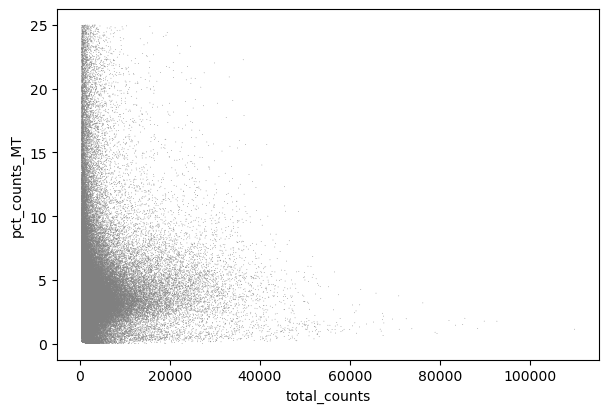

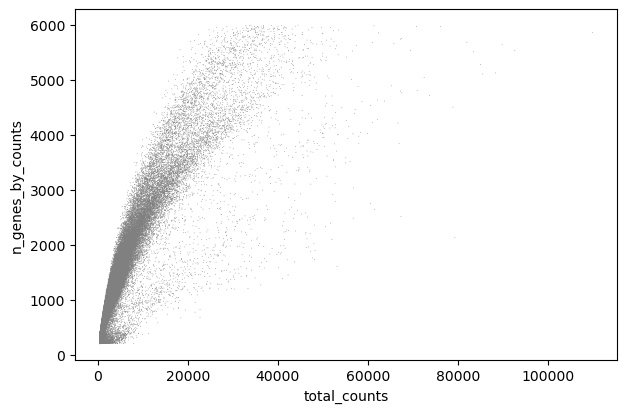

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

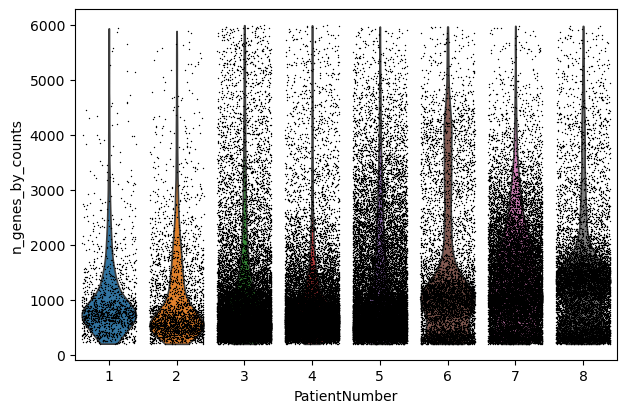

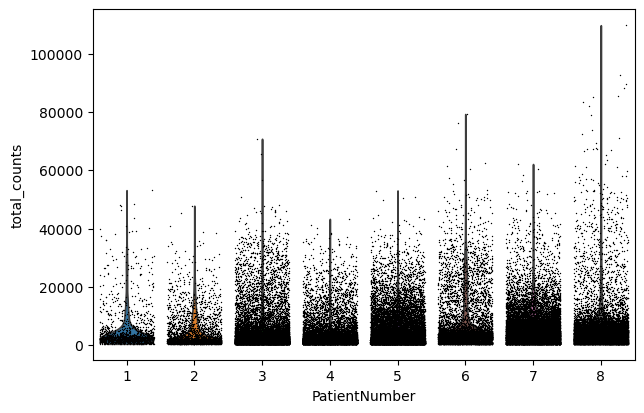

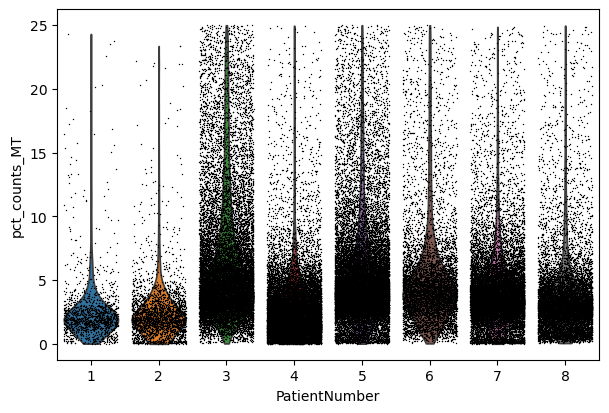

In [13]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [14]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] > 200]
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata.shape

CPU times: user 22.6 ms, sys: 957 µs, total: 23.5 ms
Wall time: 22.9 ms


(92666, 33694)

In [15]:
%%time
adata = adata[adata.obs["pct_counts_MT"] < 20]
adata.shape

CPU times: user 7.91 ms, sys: 1.87 ms, total: 9.78 ms
Wall time: 9.4 ms


(91180, 33694)

We also filter out genes that are expressed in less than 3 cells.

In [16]:
%%time
rsc.pp.filter_genes(adata,min_count=3)

filtered out 8034 genes based on n_cells_by_counts
CPU times: user 51.7 ms, sys: 27.6 ms, total: 79.3 ms
Wall time: 92.1 ms


We store the raw expression counts in the `.layer["counts"]`

In [17]:
adata.layers["counts"] = adata.X.copy()

In [18]:
adata.shape

(91180, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [19]:
%%time
rsc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 244 µs, sys: 997 µs, total: 1.24 ms
Wall time: 7.06 ms


Next, we log transform the count matrix.

In [20]:
%%time
rsc.pp.log1p(adata)

CPU times: user 85 µs, sys: 1.96 ms, total: 2.04 ms
Wall time: 2.02 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [21]:
%%time
rsc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="seurat_v3",batch_key= "PatientNumber",layer = "counts")

CPU times: user 1.13 s, sys: 3.38 s, total: 4.51 s
Wall time: 633 ms


Now we safe this verion of the AnnData as adata.raw.

In [22]:
%%time
adata.raw = adata

CPU times: user 72 ms, sys: 49.2 ms, total: 121 ms
Wall time: 120 ms


Now we restrict our AnnData object to the highly variable genes.

In [23]:
%%time
adata = adata[:,adata.var["highly_variable"]==True]

CPU times: user 56.3 ms, sys: 58.6 ms, total: 115 ms
Wall time: 114 ms


In [24]:
adata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [25]:
%%time
rsc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 633 ms, sys: 814 ms, total: 1.45 s
Wall time: 1.48 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [26]:
%%time
rsc.pp.scale(adata,max_value=10)

CPU times: user 29.2 ms, sys: 2.3 ms, total: 31.5 ms
Wall time: 43.7 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuMLs.

In [27]:
%%time
rsc.pp.pca(adata, n_comps = 100)

CPU times: user 682 ms, sys: 86.3 ms, total: 768 ms
Wall time: 780 ms


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

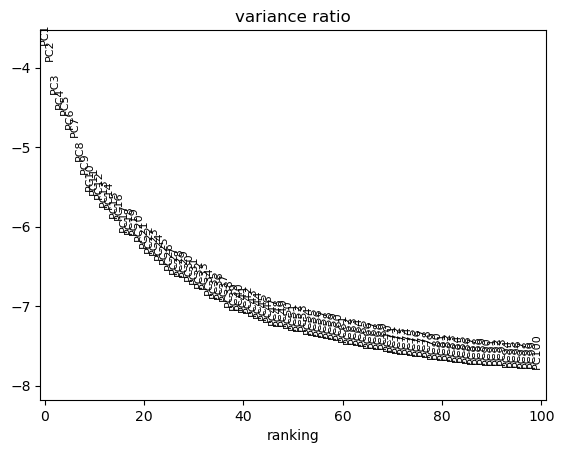

In [28]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [29]:
%%time
rsc.utils.anndata_to_CPU(adata, convert_all=True)

CPU times: user 165 ms, sys: 133 ms, total: 298 ms
Wall time: 298 ms


In [30]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 6.993209362030029


We have now finished the preprocessing of the data.

## Batch Correction

In [31]:
%%time
rsc.pp.harmony_integrate(adata,key="PatientNumber")

2024-01-03 16:45:03,593 - harmonypy_gpu - INFO - Iteration 1 of 10
2024-01-03 16:45:05,926 - harmonypy_gpu - INFO - Iteration 2 of 10
2024-01-03 16:45:08,202 - harmonypy_gpu - INFO - Iteration 3 of 10
2024-01-03 16:45:10,477 - harmonypy_gpu - INFO - Iteration 4 of 10
2024-01-03 16:45:12,274 - harmonypy_gpu - INFO - Iteration 5 of 10
2024-01-03 16:45:13,592 - harmonypy_gpu - INFO - Iteration 6 of 10
2024-01-03 16:45:15,303 - harmonypy_gpu - INFO - Iteration 7 of 10
2024-01-03 16:45:16,525 - harmonypy_gpu - INFO - Iteration 8 of 10
2024-01-03 16:45:18,328 - harmonypy_gpu - INFO - Converged after 8 iterations


CPU times: user 6.44 s, sys: 8.38 s, total: 14.8 s
Wall time: 15 s


## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [32]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 242 ms, sys: 27.9 ms, total: 270 ms
Wall time: 272 ms


Next we calculate the UMAP embedding using rapdis.

In [33]:
%%time
rsc.tl.umap(adata)

CPU times: user 251 ms, sys: 15.9 ms, total: 267 ms
Wall time: 266 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [34]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 3.4 s, sys: 679 ms, total: 4.08 s
Wall time: 5.99 s


In [35]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 391 ms, sys: 453 ms, total: 843 ms
Wall time: 843 ms


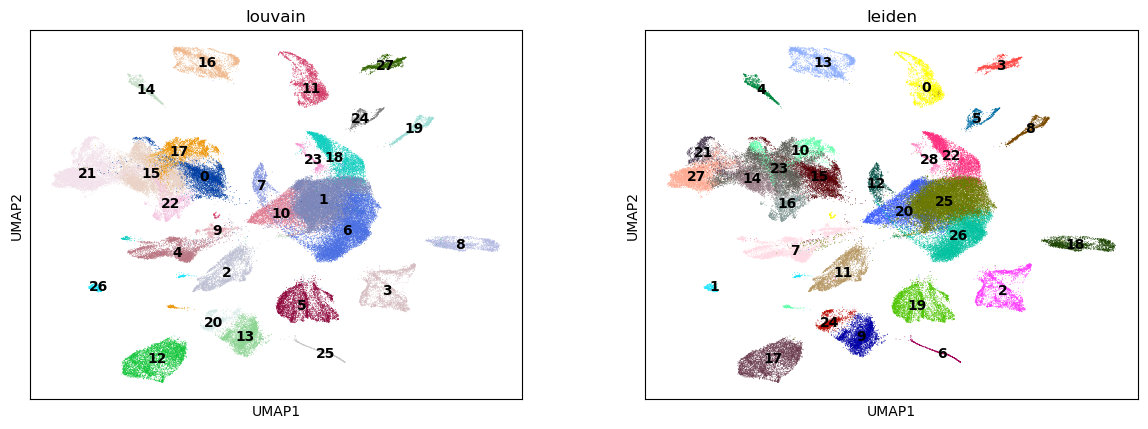

CPU times: user 577 ms, sys: 155 ms, total: 732 ms
Wall time: 553 ms


In [36]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

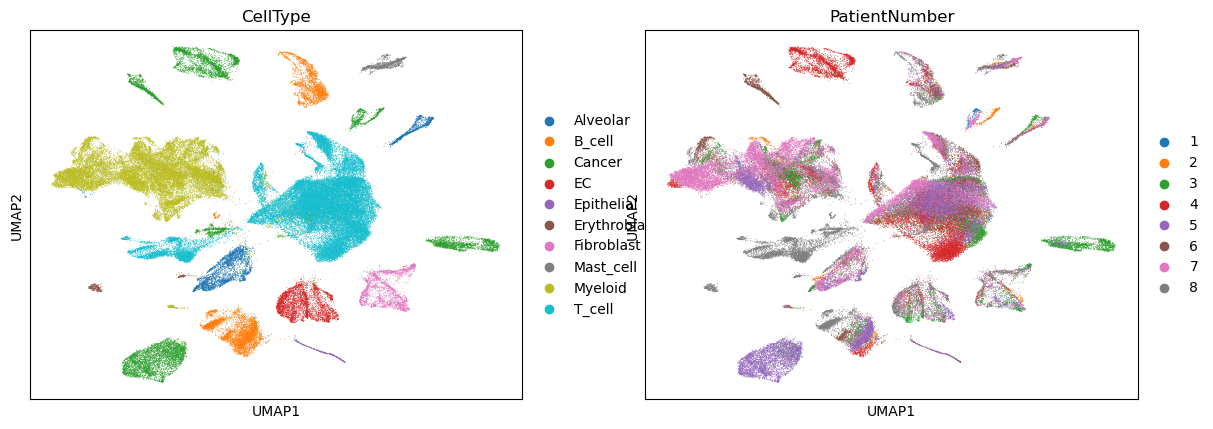

In [37]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

We also caluclate the embedding density in the UMAP using cuML

In [38]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 471 ms, sys: 73.9 ms, total: 545 ms
Wall time: 672 ms


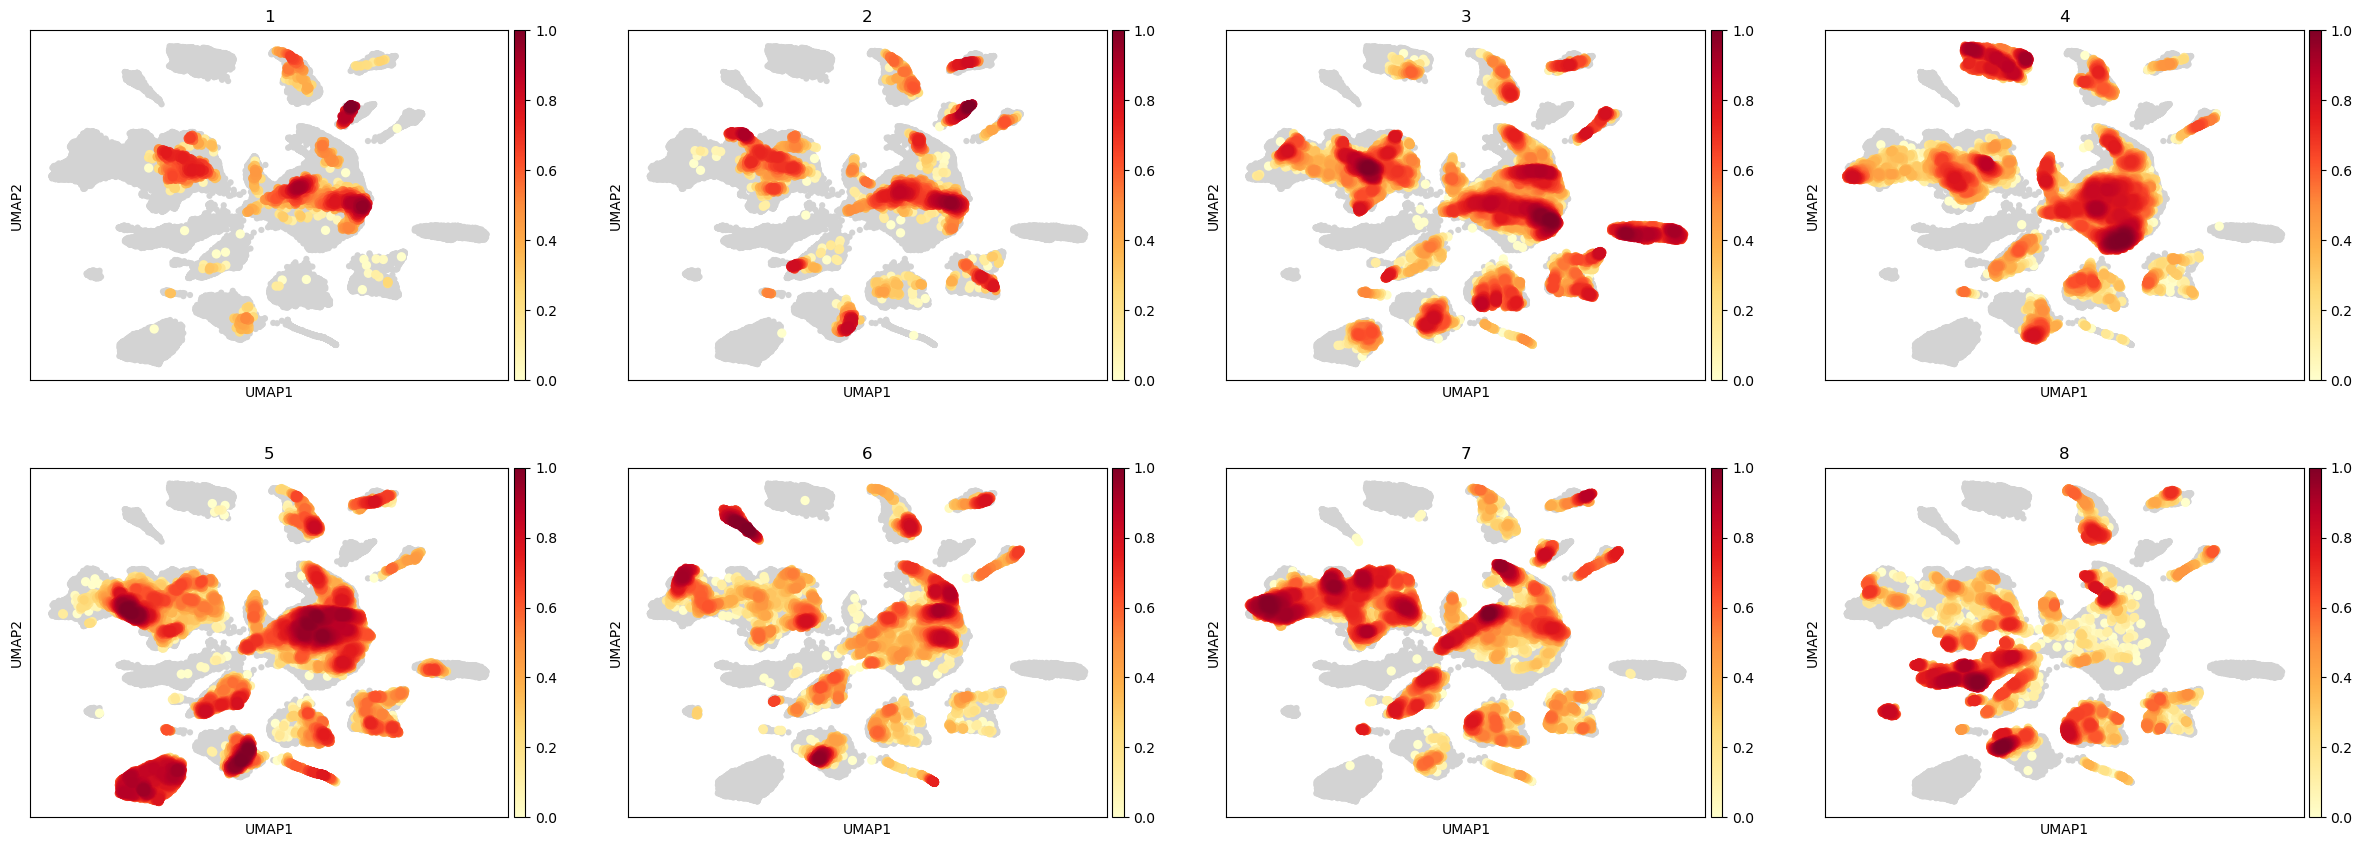

In [39]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [40]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

[W] [16:45:30.468659] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.21 s, sys: 1.38 s, total: 2.59 s
Wall time: 2.59 s


In [41]:
rsc.tl.kmeans(adata, n_clusters=8)

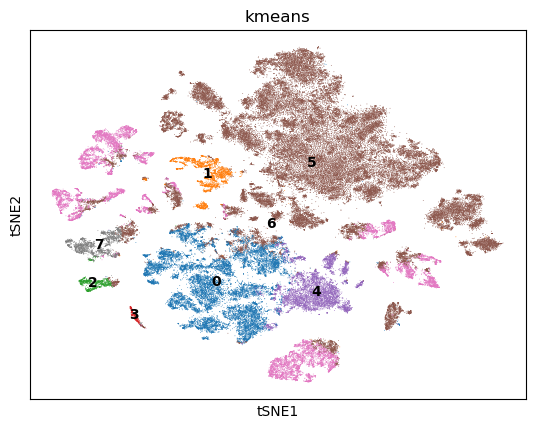

CPU times: user 307 ms, sys: 149 ms, total: 455 ms
Wall time: 273 ms


In [42]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

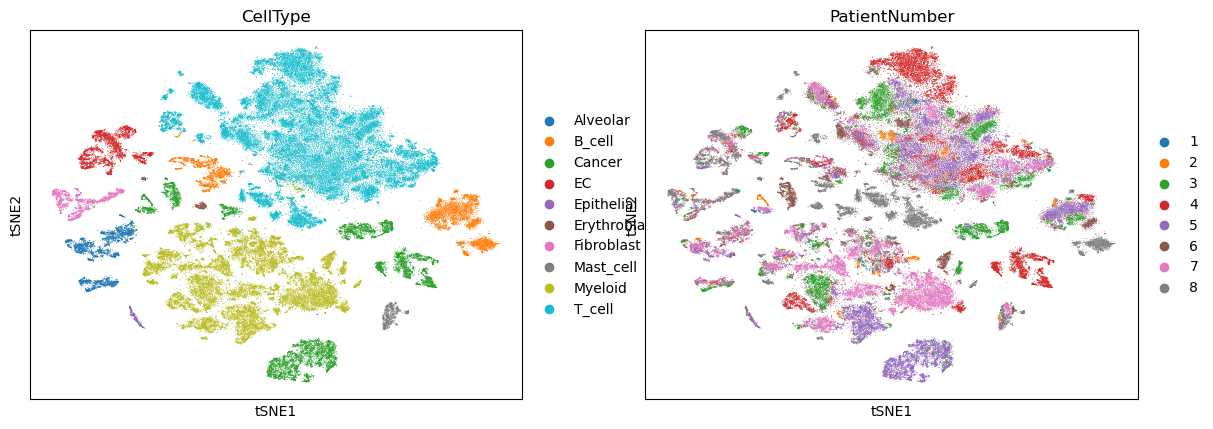

In [43]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [44]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 1.94 s, sys: 971 ms, total: 2.92 s
Wall time: 2.94 s


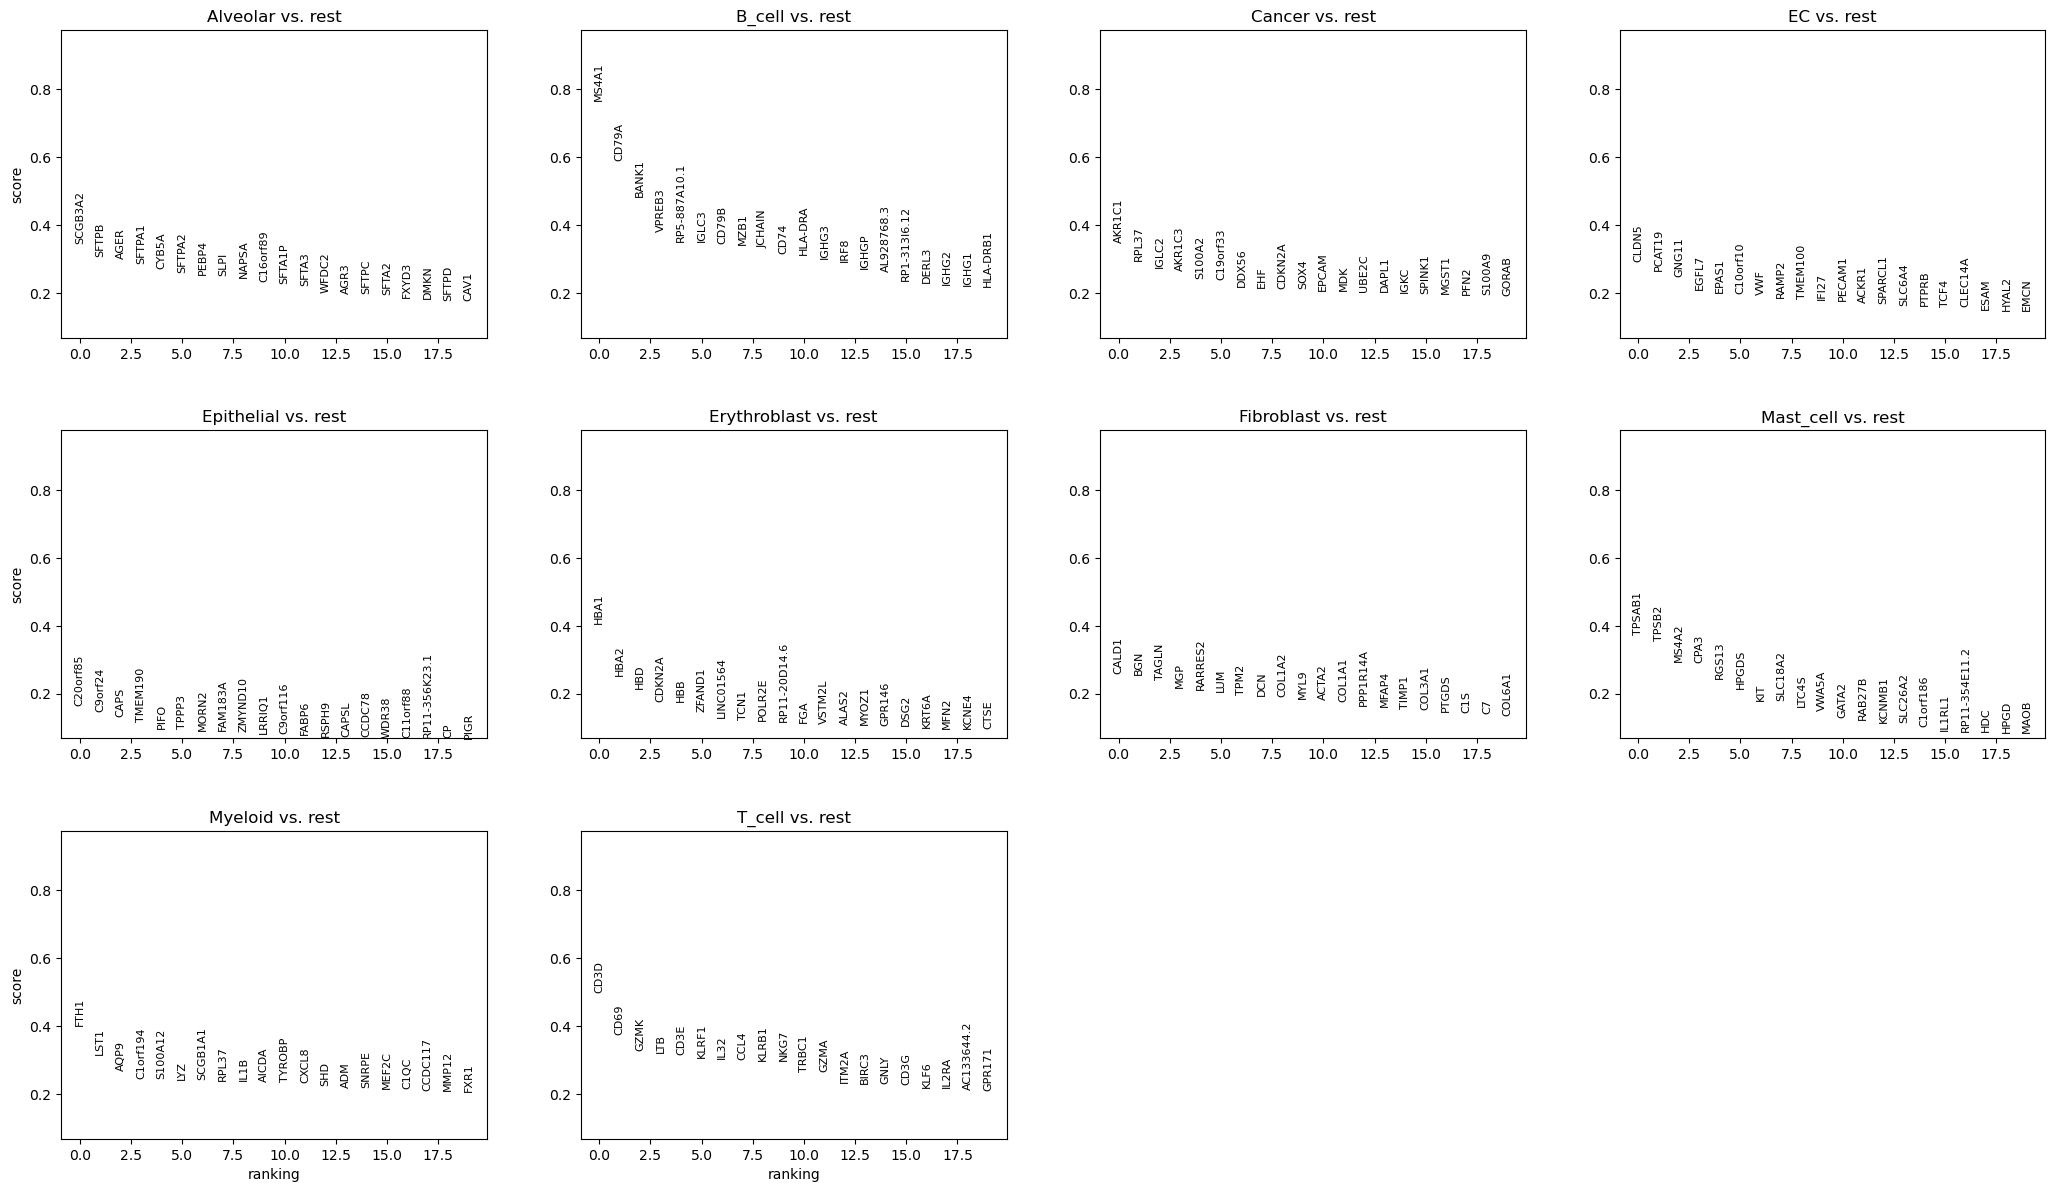

CPU times: user 915 ms, sys: 170 ms, total: 1.08 s
Wall time: 904 ms


In [45]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [46]:
post_time = time.time()

In [47]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 34.70241689682007


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [48]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

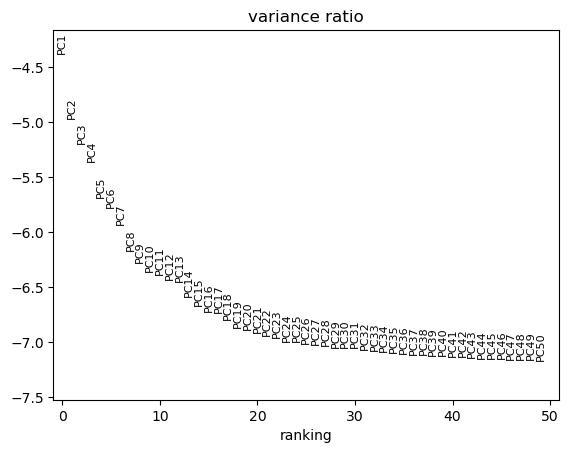

CPU times: user 869 ms, sys: 467 ms, total: 1.34 s
Wall time: 1.16 s


In [49]:
%%time
rsc.tl.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [50]:
%%time
rsc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
rsc.tl.umap(tdata)
rsc.tl.louvain(tdata)

CPU times: user 345 ms, sys: 272 ms, total: 617 ms
Wall time: 618 ms


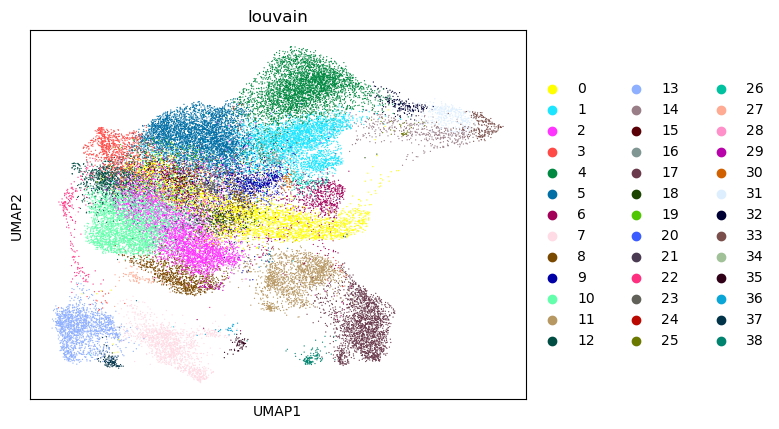

In [51]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis.

In [52]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 426 ms, sys: 1.43 s, total: 1.85 s
Wall time: 192 ms


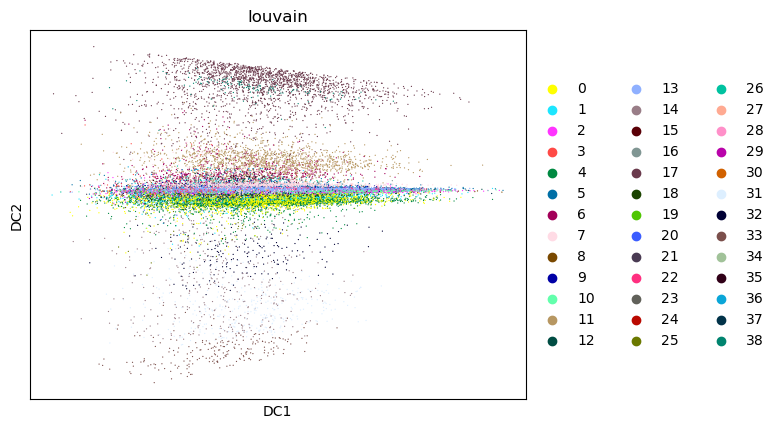

In [53]:
sc.pl.diffmap(tdata, color='louvain')

In [54]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 342 ms, sys: 12.3 ms, total: 354 ms
Wall time: 373 ms


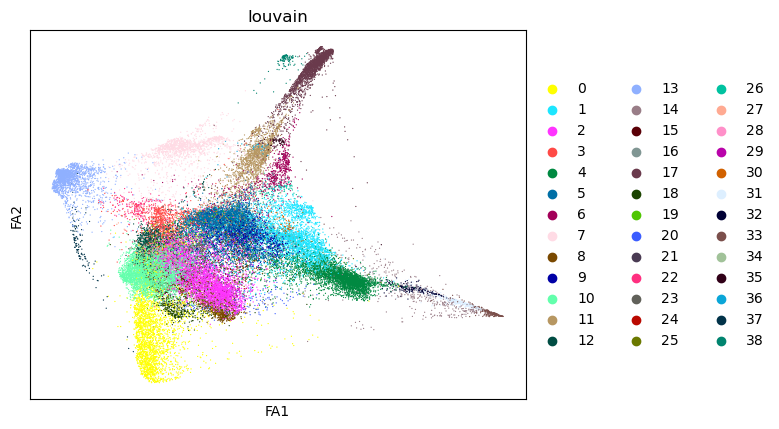

In [55]:
sc.pl.draw_graph(tdata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [56]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 46.092045545578
